In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Liquidity Adjusted VaR

Bid-ask spread is considered to be a proxy for modeling the liquidity in the market. Liquidity is a widespread financial phenomenon. Liquidity can be defined as the easiness of the trasaction with which assets can be sold in a very short time period without a significant impact on market price. 


In [4]:
bid_ask = pd.read_csv('bid_ask.csv')

In [5]:
bid_ask.head()

,Unnamed: 0,Date,EXCHCD,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,OPENPRC,vwretx
0,1031570,2019-01-02,3.0,INTC,INTEL CORP,45.77,47.470,47.08,18761673.0,0.003196,4564000.0,45.960,0.001783
1,1031571,2019-01-03,3.0,INTC,INTEL CORP,44.39,46.280,44.49,32254097.0,-0.055013,4564000.0,46.150,-0.021219
2,1031572,2019-01-04,3.0,INTC,INTEL CORP,45.54,47.570,47.22,35419836.0,0.061362,4564000.0,45.835,0.033399
3,1031573,2019-01-07,3.0,INTC,INTEL CORP,46.75,47.995,47.44,22724997.0,0.004659,4564000.0,47.100,0.009191
4,1031574,2019-01-08,3.0,INTC,INTEL CORP,46.78,48.030,47.74,22721240.0,0.006324,4564000.0,47.800,0.010240


Following are the common bid-ask spreads used to model liquidity:
    
* Effective Spread
* Proportional Quoted Spread
* Quoted Spread
* Proportional Effective Spread
* Effective Cost 

\begin{equation}
\text{Effective Spread}=2|(P_t-P_{mid})|
\end{equation}




where $P_t$ is the price of trade at time t and $P_{mid}$ is the midpoint of the bid-ask offer ($(P_{ask}-P_{bid})/2$) prevailing at the time of the $t$.



\begin{equation}
\text{Proportional Quoted Spread}=(P_{ask} - P_{bid}) / P_{mid}
\end{equation}

where $P_{ask}$ is the ask price and $P_{bid}$ and $P_{mid}$ are bid price and mid price, respectively.



\begin{equation}
\text{Quoted Spread}= P_{ask} - P_{bid}
\end{equation}

\begin{equation}
\text{Proportional Effective Spread}= 2(|P_t-P_{mid}|) / P_{mid}
\end{equation}


\begin{equation}
\text{Effective Cost}= \left  \{
  \begin{array}{lr}
  (P_t-P_{mid})/P_{mid}\text{ for buyer initiated}\\
  (P_{mid}/P_t)/P_{mid}\text{ for seller initiated}\\
   \end{array}
\right.
\end{equation}


Buyer-initiated trade occurs when a trade is executed at a price abover quoted mid price. Similarly, seller-initiated trade occurs when a trade is executed at a price below than the quoted mid price.



In [6]:
bid_ask['mid_price'] = (bid_ask['ASKHI'] + bid_ask['BIDLO']) / 2
buyer_seller_initiated = []
for i in range(len(bid_ask)):
    if bid_ask['PRC'][i] > bid_ask['mid_price'][i]:
        buyer_seller_initiated.append(1)
    else:
        buyer_seller_initiated.append(0)
        
bid_ask['buyer_seller_init'] = buyer_seller_initiated   

In [7]:
effective_cost = []
for i in range(len(bid_ask)):
    if bid_ask['buyer_seller_init'][i] == 1:
        effective_cost.append((bid_ask['PRC'][i] - 
                               bid_ask['mid_price'][i]) / 
                               bid_ask['mid_price'][i])
    else:
        effective_cost.append((bid_ask['mid_price'][i] - 
                               bid_ask['PRC'][i])/
                               bid_ask['mid_price'][i])
bid_ask['effective_cost'] = effective_cost

In [8]:
bid_ask['quoted'] = bid_ask['ASKHI'] - bid_ask['BIDLO']
bid_ask['prop_quoted'] = (bid_ask['ASKHI'] - bid_ask['BIDLO']) /\
                         bid_ask['mid_price']
bid_ask['effective'] = 2 * abs(bid_ask['PRC'] - bid_ask['mid_price'])
bid_ask['prop_effective'] = 2 * abs(bid_ask['PRC'] - 
                                    bid_ask['mid_price']) /\
                                    bid_ask['PRC']

In [9]:
bid_ask.to_csv('bid_ask_revised.csv')

The last five columns of the `bid_ask` data contain our bid-ask spread calculations:

In [10]:
spread_meas = bid_ask.iloc[:, -5:]
spread_meas

,effective_cost,quoted,prop_quoted,effective,prop_effective
0,0.009867,1.70000,0.036465,0.92000,0.019541
1,0.018639,1.89000,0.041690,1.69000,0.037986
2,0.014284,2.03000,0.043604,1.33000,0.028166
3,0.001425,1.24500,0.026281,0.13500,0.002846
4,0.007067,1.25000,0.026369,0.67000,0.014034
...,...,...,...,...,...
751,0.000999,1.01000,0.007475,0.27000,0.002000
752,0.000502,0.65551,0.004856,0.13549,0.001004
753,0.000296,0.88000,0.006504,0.08000,0.000591
754,0.008140,2.80000,0.020911,2.18000,0.016414


Let us check the correlation structure of spread measures. The correlation table shows that effective cost and proportional effective spread are highly correlated. Whereas quoted and effective cost spread shows low correlation.

In [11]:
spread_meas.corr()

,effective_cost,quoted,prop_quoted,effective,prop_effective
effective_cost,1.000000,0.441290,0.727917,0.800894,0.999847
quoted,0.441290,1.000000,0.628526,0.717246,0.442053
prop_quoted,0.727917,0.628526,1.000000,0.514979,0.728687
effective,0.800894,0.717246,0.514979,1.000000,0.800713
prop_effective,0.999847,0.442053,0.728687,0.800713,1.000000


All right, now the question how we can make use of these variables? This is the point where Principal Component Analysis (PCA) comes into the stage. Utilizing PCA, you will be able to obtain components by which you can represent a significant portion of the variance of the original data (`bid_ask`).

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

As you have 5 variables (bid-ask spreads), the number of components will be 5 at first in running PCA. Then, you check the variance explained. In theory, there are different methods used to define the optimal number of components. Of them, cutting-off the analysis when you reached a point at which principal components can account for 80\% of the variance of original data makes sense for practical purpose.

So, depending on the number of components used to account for 80\% of the variance, it becomes the optimal number of components.

In [13]:
scaler = StandardScaler()
spread_meas_scaled = scaler.fit_transform(np.abs(spread_meas))
pca = PCA(n_components=5)
prin_comp = pca.fit_transform(spread_meas_scaled)

It turns out first two components are able to explain the 80\% of the variance and 2 components is the optimum number for us.

In [14]:
var_expl = np.round(pca.explained_variance_ratio_, decimals=4)
cum_var = np.cumsum(np.round(pca.explained_variance_ratio_,
                             decimals=4))
print('Individually Explained Variances are:\n{}'.format(var_expl)) 
print('=='*30)
print('Cumulative Explained Variances are: {}'.format(cum_var))  

Individually Explained Variances are:
[0.7494 0.1461 0.0983 0.0062 0.    ]
Cumulative Explained Variances are: [0.7494 0.8955 0.9938 1.     1.    ]


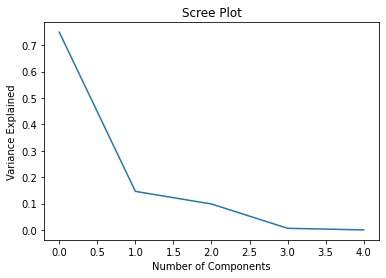

In [15]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

So, let's re-run the PCA with 2 components as we found the optimal number of components.

In [16]:
pca = PCA(n_components=2)
pca.fit(np.abs(spread_meas_scaled))
prin_comp = pca.transform(np.abs(spread_meas_scaled))
prin_comp = pd.DataFrame(np.abs(prin_comp), columns = ['Component 1',
                                                       'Component 2'])
print(pca.explained_variance_ratio_ * 100)  

[65.65640435 19.29704671]


This is the crucial part. Because, you need to define a way in which you can use the principal components in the analysis. One of the ways is to calculate mean value of these two principal components. But before doing this, you need to rescale the principal components as you standardized the data before running PCA.

Recall the standardization formula, which is:

\begin{equation}
z = \frac{x - \mu}{\sigma}
\end{equation}

Thus, if you leave x alone, the formula you need to apply for rescaling emerges:

\begin{equation}
x = z *\sigma + \mu 
\end{equation}

In [17]:
prin_comp1_rescaled = prin_comp.iloc[:,0] * prin_comp.iloc[:,0].std()\
                      + prin_comp.iloc[:, 0].mean()
prin_comp2_rescaled = prin_comp.iloc[:,1] * prin_comp.iloc[:,1].std()\
                      + prin_comp.iloc[:, 1].mean()
prin_comp_rescaled = pd.concat([prin_comp1_rescaled, 
                                prin_comp2_rescaled],
                               axis=1)
prin_comp_rescaled.head()

,Component 1,Component 2
0,1.766661,1.256192
1,4.835170,1.939466
2,3.611486,1.551059
3,0.962666,0.601529
4,0.831065,0.734612


Then, you are ready to calculate the mean value of the principal components to end up with a single variable representing both components.

In [18]:
mean_pca_liq = prin_comp_rescaled.mean(axis=1).mean()
mean_pca_liq

1.0647130086973808

Liqudity adjusted VaR, VaR_Liq, formula is given below. The formula consists of two part:

* VaR and
* Liqudity adjustment

\begin{equation}
\text{VaR_Liq}= \text{VaR} +\text{Liquidity Adjustment}
\end{equation}

\begin{equation}
\text{VaR_Liq}= \text{VaR} + \frac{1}{2}P_{mid}(\mu_{pca}+k\sigma_{pca})
\end{equation}

For the given confidence level of 95\%, standard normal distribution percentile become 1.96, which is represented by k.

So, let's put the pieces together and interpret the result of liqudity adjusted VaR.

In [19]:
pca_std = prin_comp_rescaled.mean(axis=1).std()
pm = bid_ask['mid_price'].mean()
k = 1.96

In [20]:
def LVaR (VaR_param, pm, mean_pca_liq, k, pca_std):
    LVaR = VaR_param + (1/2) * pm * (mean_pca_liq + k * pca_std)
    print('The liquidity Adjusted VaR is {}'.format(np.round(LVaR, 2)))

In [21]:
LVaR (VaR_param, pm, mean_pca_liq, k, pca_std)

NameError: name 'VaR_param' is not defined

As expected, when liqudity dimension is considered the expected loss turns out to be greater than the palin VaR application. To be more concrete, liquidity adjusted VaR is $\$55142$, which is almost $\$5000$ greater than the variance-covariance VaR result, which is $55030.97.

Long story short, taking liquidity into account in estimating the market risk gives us a more realiable and encompassing result.